# Feature Engineering & Selection

**Author:** Ethan Davis  
**Affiliation:** University of Washington  
**Contact:** davise5@uw.edu  
**Date:** February 2026

## Introduction

Statistical models are ubiquitous in modern society. For example, when modeling the sale price of a house the characteristics like square footage and number of bedrooms and bathrooms can be used to make a prediction. In this case, the house price is the quantity being modeled or predicted, and is referred to as the outcome, response, or dependent variable. The variables or characteristics used to model the outcome are called the predictors, features, or independent variables. We could also consider the number of bedrooms per bathroom, creating a *derived feature*. The idea that there are different ways to represent features in a model, and that some of these representations are better than others at increasing the effectiveness of the model, leads to the idea of *feature engineering* [Kuhn2019].

On the other side of feature engineering is model selection. The "No Free Lunch" Theorem tells us that no single model is optimized for all types of data. For example, one model might be optimized for collinear features but be constrained to linear trends and missing data. In practice it's best to try multiple types of models to probe which one works best for a particular dataset. Furthermore, any chosen model must be tuned to avoid overfitting to training data. Forms of regularization should be used to create flexible and moderately biased models. At the same time, we must find a balance to avoid over regularization that produces models that are too simple and underfit. This is known as the bias-variance tradeoff [Kuhn2019].



![EEG instrumentation](https://raw.githubusercontent.com/davisethan/FeatureEngineering/main/assets/bias-variance.jpeg)

Example of the bias-variance tradeoff [Star2021].

In this notebook we'll be using data from motor-imagery electroencephalogram (MI-EEG) to model left vs. right hand imagery; i.e. imagined movement of the left vs. right hand. Brain-computer interfacing (BCI) is active research for motor rehabilitation and neuroprosthetics in academia and companies like Neuralink [Nam2018]. EEG experiments are designed with a composition of sessions, runs, and trials. A *session* is a series of runs where EEG electrodes remain attached to a subject's head. The term *run* refers to a period during which an experiment is conducted without interruption. Within a session, several runs are completed with potential intervals between them. A *trial* denotes a segment within a run where an atomic event occurs, such as left or right hand imagery [Chevallier2024].

![EEG instrumentation](https://raw.githubusercontent.com/davisethan/FeatureEngineering/main/assets/experiment.png)

EEG experiment design. (Left) A subject wears an EEG device for an experiment during which instructions appear on the screen directing them to imagine movement of their left or right hand. (Right) A montage of EEG electrodes uniquely labeled by their placement and that collect electrical signals froms the brain [Corsi2023].

![Human motor cortex & homunculus](https://raw.githubusercontent.com/davisethan/FeatureEngineering/main/assets/motor-cortex-homunculus.png)

The human motor cortex and homunculus. (Left) The human motor cortex that's generally captured along EEG montage channels Cz and C1-C6. (Right) The human homunculus that's represented along the sensory cortex [Cortex2014, Homunculus2016].

We'll be using the BNCI2014_001 dataset that comes from the MI-EEG paradigm. This is one of the most widely used MI-EEG datasets in BCI research, commonly referred to as "BCI Competition IV Dataset 2a", and serves as a standard benchmark for MI-EEG classification algorithms. BNCI2014_001 consists of EEG data from 9 subjects. Two sessions on different days were recorded for each subject. Each session has 6 runs separated by short breaks. One run consists of 48 trials [Tangermann2012]. Although BNCI2014_001 consists of four different motor imagery tasks, namely imagination of movement of the left hand (class 1), right hand (class 2), both feet (class 3), and tongue (class 4), we'll only be using the first two tasks.

The Mother of all BCI Benchmarks ([MOABB](https://moabb.neurotechx.com/docs/index.html)) centralizes publicly available EEG datasets. MOABB also encodes principled data preprocessing and multiple model evaluations: within session, cross session, and cross subject. Users bring their own scikit-learn compatible pipelines to benchmark. We'll use MOABB to download BNCI2014_001 and evaluate models of left vs. right hand imagery. MOABB also offers statistical analysis that focuses on whether the performance of one model is statistically significant compared to another model [Jayaram2018]. This approach to BCI benchmarking taken by MOABB lets researchers focus on novel feature engineering and model pipelines. We recommend MOABB to anyone interested in BCI, ML research, and open-source development.

![EEG instrumentation](https://raw.githubusercontent.com/davisethan/FeatureEngineering/main/assets/evaluation.png)

MOABB evaluations. In this notebook we're using the within session evaluation. (Left) The within session evaluation takes one session from a subject and shuffles the trials before cross-validation. (Center) The cross session (within subject) evaluation takes all sessions from a subject and holds out sessions for training and testing. (Right) The cross subject evaluation holds out subjects for cross-validaton [Chevallier2024].

In [ ]:
%pip install moabb
%pip install mne-features
%pip install braindecode "pandas==2.2.2"

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path

from moabb.datasets import BNCI2014_001
from moabb.paradigms import LeftRightImagery
from moabb.evaluations import WithinSessionEvaluation

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

# General EEG data management
# Also time and frequency domain feature extraction
from mne_bids import find_matching_paths, read_raw_bids
from mne_features.feature_extraction import FeatureExtractor

# Both CSP and Riemannian spatial filters
from pyriemann.estimation import Covariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace

# EEG domain specific deep learning
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.classifier import EEGClassifier
from skorch.callbacks import EarlyStopping, LRScheduler
from skorch.dataset import ValidSplit

In [ ]:
# Download BNCI2014_001 from MOABB
# Also save standardized human readable BIDS format
dataset = BNCI2014_001()
dataset.get_data(cache_config=dict(path="/content", save_raw=True))

## Data Exploration

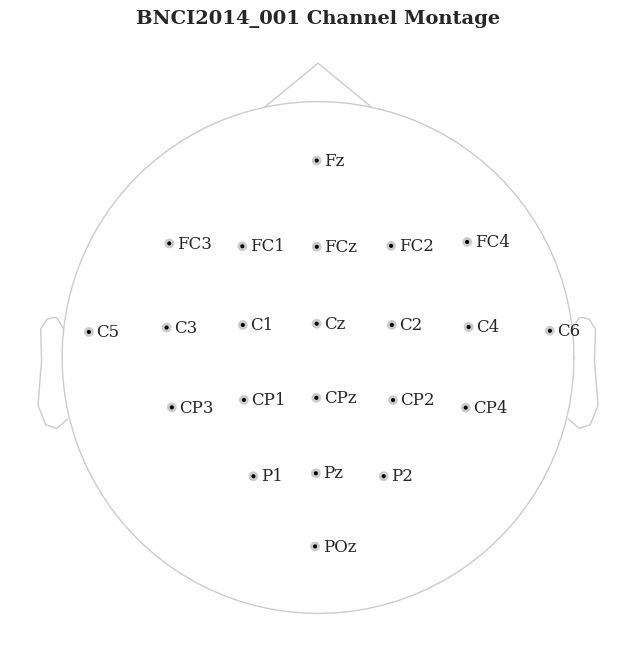

In [4]:
# Load BIDS formatted BNCI2014_001
bids_paths = find_matching_paths(
    root=path.join("/content", "MNE-BIDS-bnci2014-001"),
    subjects="1",
    datatypes="eeg",
    extensions=".edf",
)
bids_path = bids_paths[0]
raw = read_raw_bids(bids_path=bids_path, verbose=False)
raw.set_montage("standard_1020")

# Plot montage of channels
fig = raw.plot_sensors(show_names=True, sphere="auto", show=False)
plt.suptitle("BNCI2014_001 Channel Montage", fontweight="bold", fontsize=14)
plt.show()

In [5]:
# Visualize shape of BNCI2014_001
# Returns 3D tensor (n_trials, n_channels, n_timepoints)
# Also returns trial labels and contextual metadata
paradigm = LeftRightImagery()
X, y, metadata = paradigm.get_data(dataset, subjects=[1])
print(X.shape)
print(y.shape)
print(np.unique(y))
print(metadata.shape)
print(metadata.head())

(288, 22, 1001)
(288,)
['left_hand' 'right_hand']
(288, 3)
   subject session run
0        1  0train   0
1        1  0train   0
2        1  0train   0
3        1  0train   0
4        1  0train   0


In [6]:
# Tabulate first 10 timepoints from first trial
df = pd.DataFrame(
    X[0, :, :10].T,
    columns=[f"Ch{i}" for i in range(X.shape[1])],
    index=[f"t{i}" for i in range(10)]
)
display(df)

,Ch0,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Ch9,...,Ch12,Ch13,Ch14,Ch15,Ch16,Ch17,Ch18,Ch19,Ch20,Ch21
t0,6.126753,5.580568,7.432791,8.661632,7.249424,5.455565,6.518764,7.300969,8.226300,9.398785,...,0.872086,7.730294,8.913029,7.931358,5.395017,1.522996,8.544257,7.465582,5.008111,8.015824
t1,4.800695,3.780743,5.461719,6.258463,5.203586,3.692261,5.359725,5.142813,5.823407,5.928947,...,0.353824,4.437227,5.538328,3.949378,1.851247,-2.010723,4.179828,3.394683,1.587276,4.227478
t2,1.893759,1.027867,2.110579,2.442679,1.718649,0.821010,2.839252,2.090544,2.251115,1.460862,...,-0.829721,0.420967,1.140697,-0.709234,-2.228916,-5.490041,-0.877190,-1.155047,-2.115821,-0.141063
t3,-1.663054,-1.914050,-1.578304,-1.820030,-2.194483,-2.313092,-0.380625,-1.026610,-1.497124,-2.838818,...,-2.265625,-3.351452,-3.131508,-4.792798,-5.740190,-7.993501,-5.362817,-5.102905,-5.302077,-4.205716
t4,-4.545979,-4.131734,-4.332571,-5.278499,-5.233925,-4.675658,-3.312769,-3.345234,-4.297867,-5.845121,...,-3.302770,-5.971075,-6.133527,-7.262156,-7.742818,-8.862546,-8.204508,-7.576767,-7.326630,-7.191677
t5,-5.612841,-4.909504,-5.192077,-6.891393,-6.353136,-5.449518,-5.053011,-4.280888,-5.344819,-6.883916,...,-3.316185,-6.906094,-7.159279,-7.650539,-7.780250,-7.889305,-8.887484,-8.179949,-7.860677,-8.617844
t6,-4.448750,-4.047002,-3.961789,-6.291035,-5.239625,-4.388246,-5.174259,-3.754993,-4.500191,-5.983123,...,-2.016445,-6.189754,-6.215062,-6.193567,-6.013571,-5.351049,-7.600345,-7.078061,-6.949040,-8.388197
t7,-1.589641,-1.979169,-1.327282,-3.965758,-2.473989,-1.944515,-3.901709,-2.220563,-2.359057,-3.837276,...,0.342440,-4.375940,-3.986795,-3.675313,-3.126403,-1.903402,-5.095630,-4.876969,-4.957767,-6.773900
t8,1.709217,0.391574,1.448221,-1.044278,0.723886,0.904119,-1.975709,-0.457287,0.021788,-1.488162,...,2.983307,-2.272298,-1.510145,-1.069884,-0.049831,1.618871,-2.338534,-2.356339,-2.441771,-4.304999
t9,4.049190,2.091405,3.102568,1.221594,3.041661,3.067172,-0.276779,0.777213,1.601512,0.133325,...,4.890387,-0.579372,0.292870,0.849544,2.375853,4.435552,-0.114951,-0.179773,0.021652,-1.608684


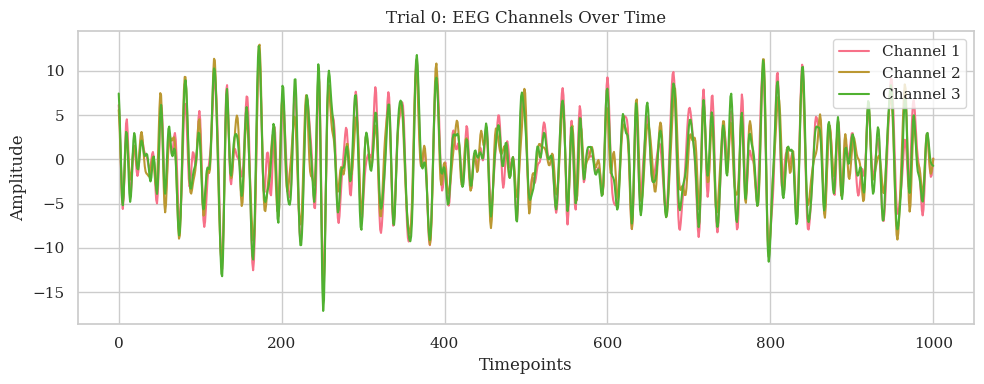

In [7]:
# Plot raw signals from a subset of channels from the first trial
plt.figure(figsize=(10, 4))
plt.plot(X[0][0:3].T)
plt.title("Trial 0: EEG Channels Over Time")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")
plt.legend([f"Channel {i + 1}" for i in range(3)], loc="upper right")
plt.tight_layout()
plt.show()

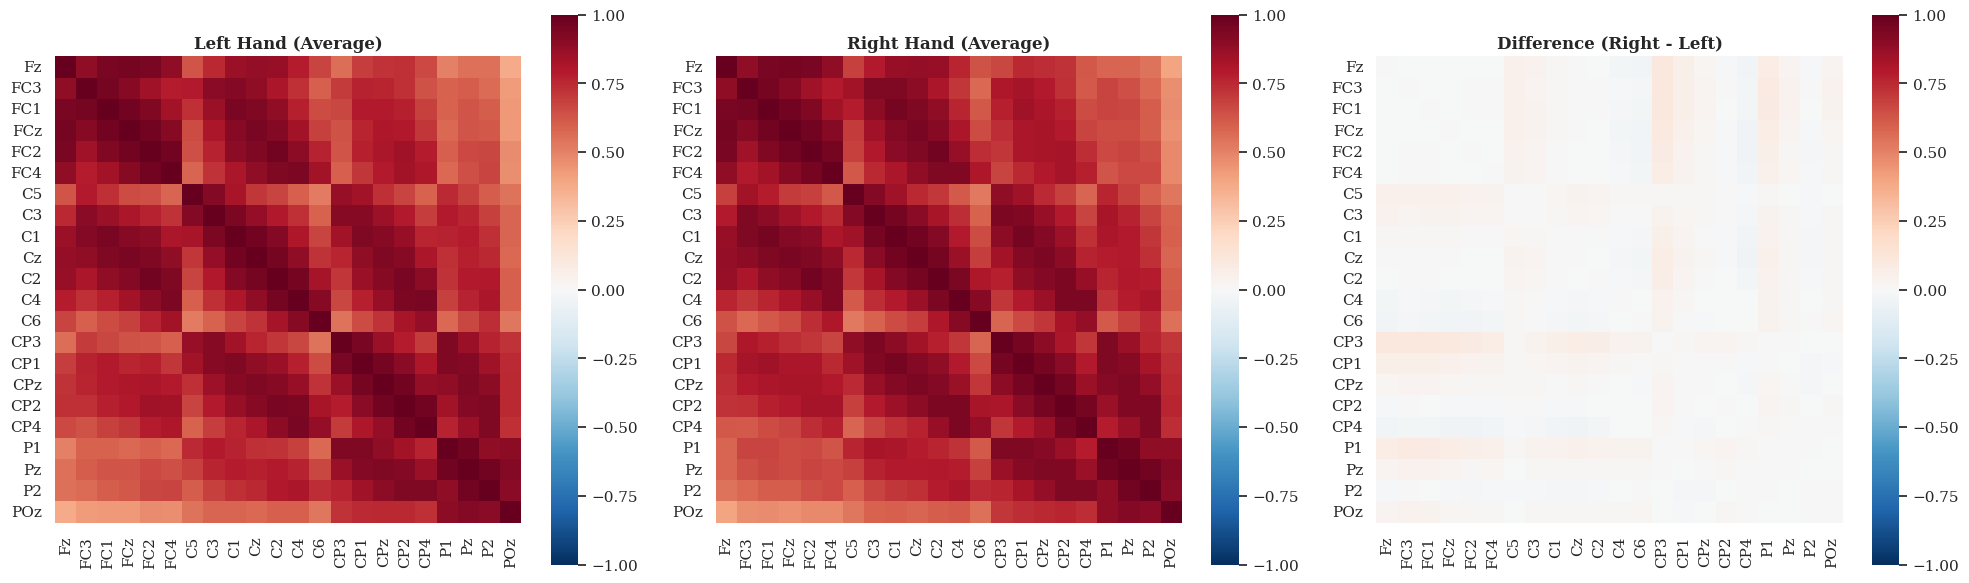

In [8]:
def avg_correlation(trials):
    """Returns the average correlation matrix of given trials"""
    corr_matrices = []
    for trial in trials:
        corr = pd.DataFrame(trial, index=raw.ch_names).T.corr().values
        corr_matrices.append(corr)
    return np.mean(corr_matrices, axis=0)


def plot_correlation(corr_matrix, ax, title):
    """Plots a correlation matrix"""
    sns.heatmap(corr_matrix, ax=ax, xticklabels=raw.ch_names,
                yticklabels=raw.ch_names, cmap="RdBu_r", center=0,
                vmin=-1, vmax=1, square=True)
    ax.set_title(title, fontweight="bold")


# Filter trials by left vs. right hand motor imagery
left_trials = X[y == "left_hand"]
right_trials = X[y == "right_hand"]

# Compute correlation matrices
corr_left_avg = avg_correlation(left_trials)
corr_right_avg = avg_correlation(right_trials)
corr_diff = corr_right_avg - corr_left_avg

# Plot correlation matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plot_correlation(corr_left_avg, axes[0], "Left Hand (Average)")
plot_correlation(corr_right_avg, axes[1], "Right Hand (Average)")
plot_correlation(corr_diff, axes[2], "Difference (Right - Left)")
plt.tight_layout()
plt.show()


## Feature Engineering: Time & Frequency Domain

For many years early BCI research was centered around specialized knowledge in signal processing for feature engineering in the time and frequency domains [Nam2018]. Some of the earliest and most widely used feature engineering and selection for EEG models included power and energy features from frequency bands and Hjorth parameters [Pfurtscheller1999, Hjorth1970]. These are derived features extracted from each channel and therefore the total number of predictors scales proportional to the number of selected features and channels. It's recommended to perform principal component analysis (PCA) before fitting ML models to avoid the curse of dimensionality. We use [MNE-features](https://mne.tools/mne-features/api.html) for time and frequency domain feature engineering which encodes many features useful for BCI research.

![Frequency bands](https://raw.githubusercontent.com/davisethan/FeatureEngineering/main/assets/frequency.jpeg)

Delta and Theta bands are found in deep and light sleep, respectively. Alpha (8-12 Hz in posterior areas) and Mu (7-13 Hz in central areas) rhythms are observed in quiet watch and resting states. Beta frequency bands occur during active watch and cognitive tasks such as motor imagery. Gamma bands are observed during specific cognitive processing [Corsi2023].

In [9]:
# Extract time and frequency domain features
selected_funcs = [
    "pow_freq_bands",
    "energy_freq_bands",
    "hjorth_mobility",
    "hjorth_complexity",
]
params = {
    "pow_freq_bands__freq_bands": {
        "mu": [8, 12],
        "beta": [13, 30]
    },
    "energy_freq_bands__freq_bands": {
        "mu": [8, 12],
        "beta": [13, 30]
    }
}
fe = FeatureExtractor(sfreq=250, selected_funcs=selected_funcs, params=params)
X_features = fe.fit_transform(X)
print(X_features.shape)

(288, 132)


Create pairplots for the time and frequency domain features using just the C3 and C4 motor cortex channels.

Text(0.5, 1.02, 'Motor Cortex Features: Class Separability')

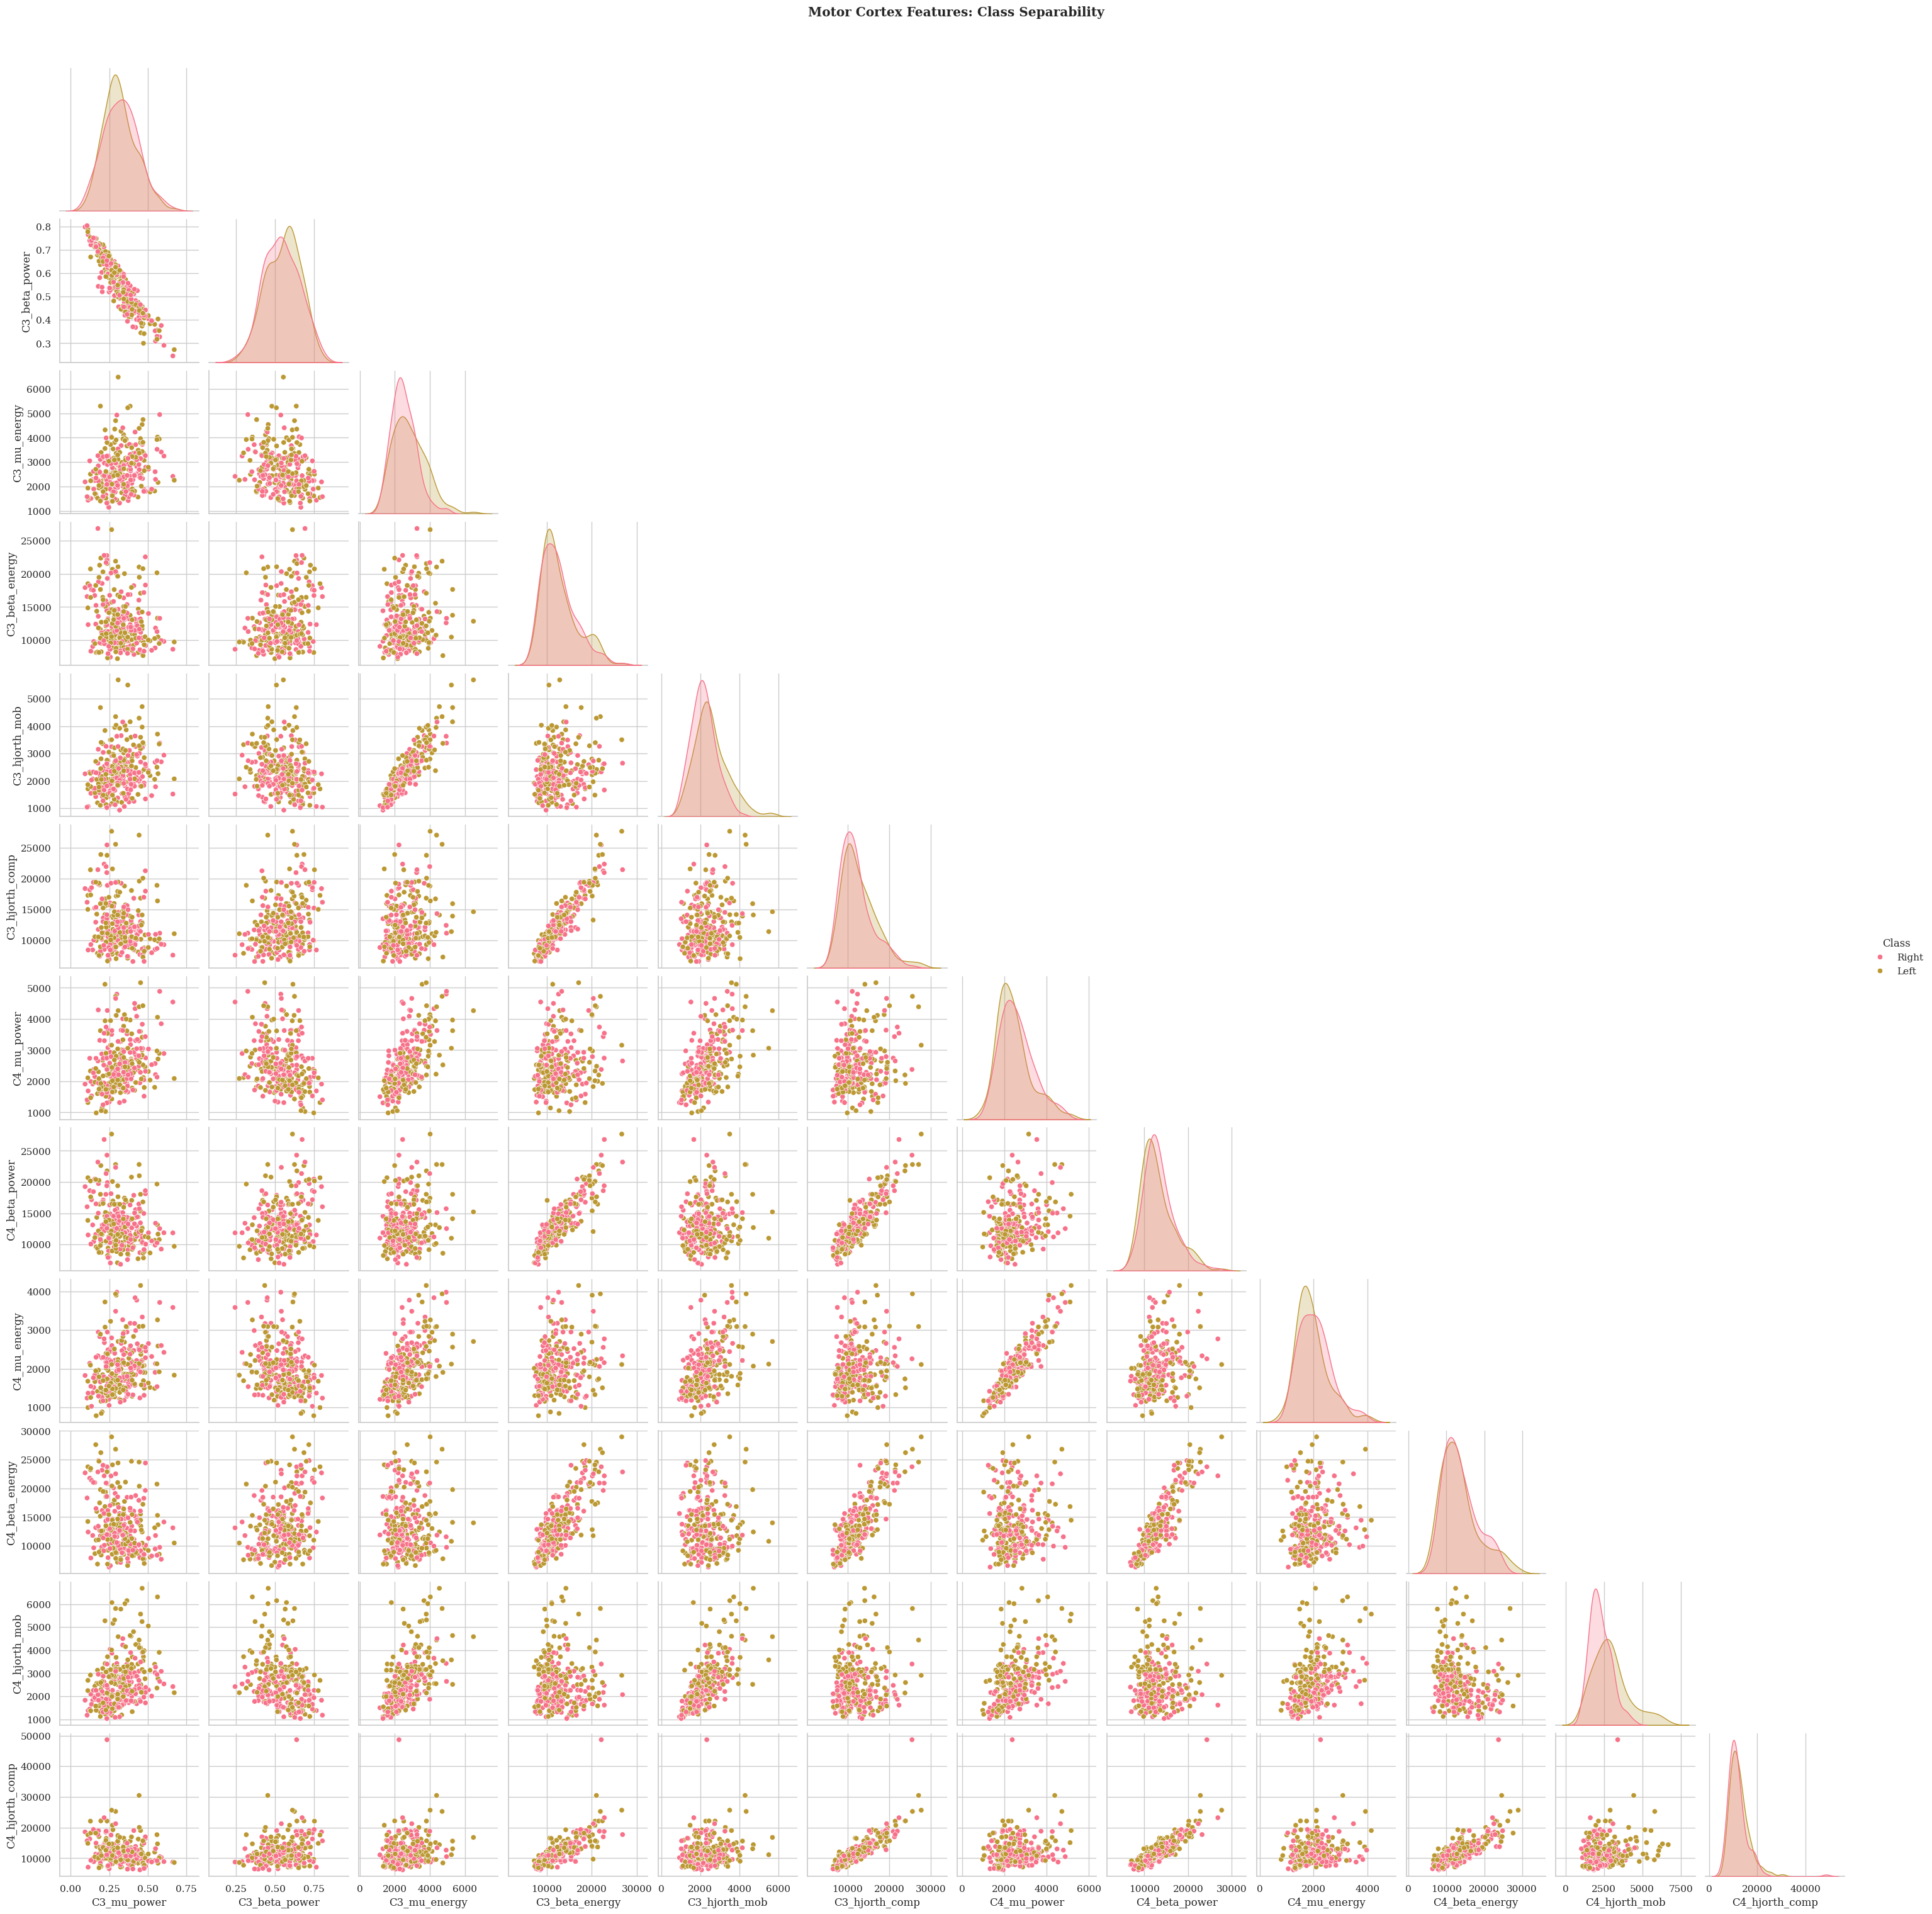

In [10]:
# Filter channels by motor cortex
channel_names = raw.ch_names
motor_channels = ["C3", "C4"]
motor_indices = [channel_names.index(ch) for ch in motor_channels]

# Index motor cortex channels
n_features_per_channel = 6
motor_feature_indices = []
for ch_idx in motor_indices:
    start = ch_idx * n_features_per_channel
    end = start + n_features_per_channel
    motor_feature_indices.extend(range(start, end))

# Create axes labels
X_motor_features = X_features[:, motor_feature_indices]
feature_types = ["mu_power", "beta_power", "mu_energy", "beta_energy",
                 "hjorth_mob", "hjorth_comp"]
feature_names = []
for ch in motor_channels:
    for feat in feature_types:
        feature_names.append(f"{ch}_{feat}")

# Create pairplot data
df = pd.DataFrame(X_motor_features, columns=feature_names)
df["Class"] = ["Left" if y[i] == "left_hand" else "Right" for i in range(len(y))]

# Visualize motor cortex pairplot
sns.pairplot(df, hue="Class", corner=True, diag_kind="kde")
plt.suptitle("Motor Cortex Features: Class Separability", y=1.02, fontweight="bold")

Analyze the principal components of the time and frequency domain features by their cumulative explained variance.

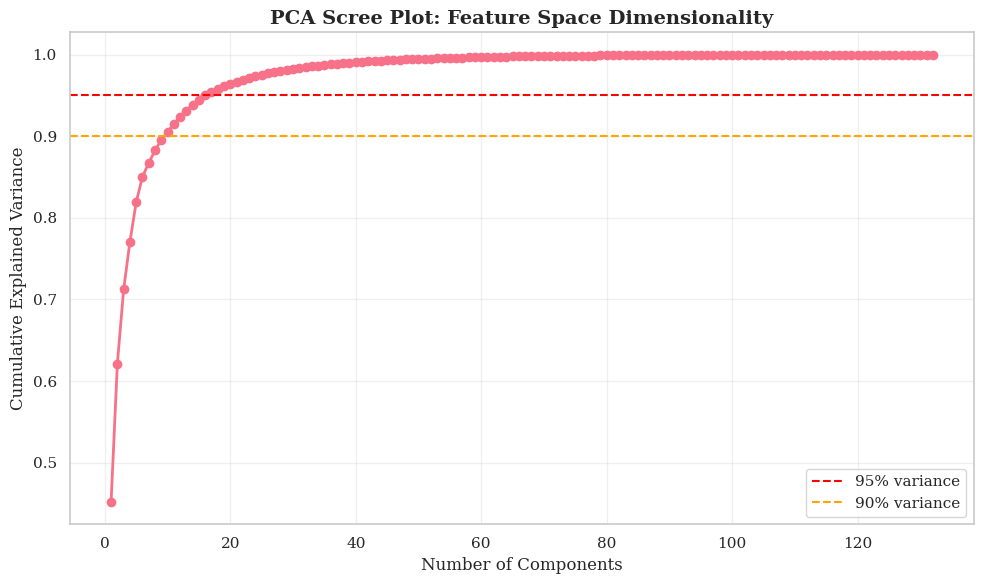

Components for 90% variance: 10
Components for 95% variance: 16
Total components: 132


In [11]:
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

pca = PCA()
pca.fit(X_features_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_),
         marker="o",
         linewidth=2,
         markersize=6)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("PCA Scree Plot: Feature Space Dimensionality", fontweight="bold", fontsize=14)
plt.axhline(y=0.95, color="r", linestyle="--", linewidth=1.5, label="95% variance")
plt.axhline(y=0.90, color="orange", linestyle="--", linewidth=1.5, label="90% variance")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
n_components_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Total components: {len(pca.explained_variance_ratio_)}")

Create our MOABB within session evaluation and first ML model pipelines and evaluate model performance by their AUROC.

In [12]:
# Create our MOABB within session evaluation
evaluation = WithinSessionEvaluation(
    datasets=[dataset],
    paradigm=paradigm,
    random_state=1,
    hdf5_path="/content",
    overwrite=False,
)

# Define our scikit-learn compatible pipelines
pipelines = {
    "TF+LDA": make_pipeline(
        FeatureExtractor(
            sfreq=250,
            selected_funcs=selected_funcs,
            params=params,
        ),
        StandardScaler(),
        PCA(n_components=0.9),
        LDA(solver="svd"),
    ),
    "TF+SVM": make_pipeline(
        FeatureExtractor(
            sfreq=250,
            selected_funcs=selected_funcs,
            params=params,
        ),
        StandardScaler(),
        PCA(n_components=0.9),
        SVC(C=1.0, kernel="rbf"),
    )
}

# Evaluate pipelines scored by AUROC
results = evaluation.process(pipelines)
print(results.shape)
print(results.head())

BNCI2014-001-WithinSession: 100%|██████████| 9/9 [06:06<00:00, 40.73s/it]


(36, 9)
      score      time  samples subject session  channels  n_sessions  \
0  0.603197  1.919217    144.0       1  0train        22           2   
1  0.568027  1.883650    144.0       1   1test        22           2   
2  0.577143  1.898738    144.0       2  0train        22           2   
3  0.462993  1.900460    144.0       2   1test        22           2   
4  0.858163  1.920561    144.0       3  0train        22           2   

        dataset pipeline  
0  BNCI2014-001   TF+SVM  
1  BNCI2014-001   TF+SVM  
2  BNCI2014-001   TF+SVM  
3  BNCI2014-001   TF+SVM  
4  BNCI2014-001   TF+SVM  


In [13]:
def plot_performance(results):
    """Grouped bar charts of within session evaluation performance"""
    results["subj"] = [str(res).zfill(2) for res in results["subject"]]
    sns.catplot(
        kind="bar",
        x="score",
        y="subj",
        hue="pipeline",
        col="dataset",
        height=12,
        aspect=0.5,
        data=results,
        orient="h",
        palette="viridis",
    )
    plt.show()

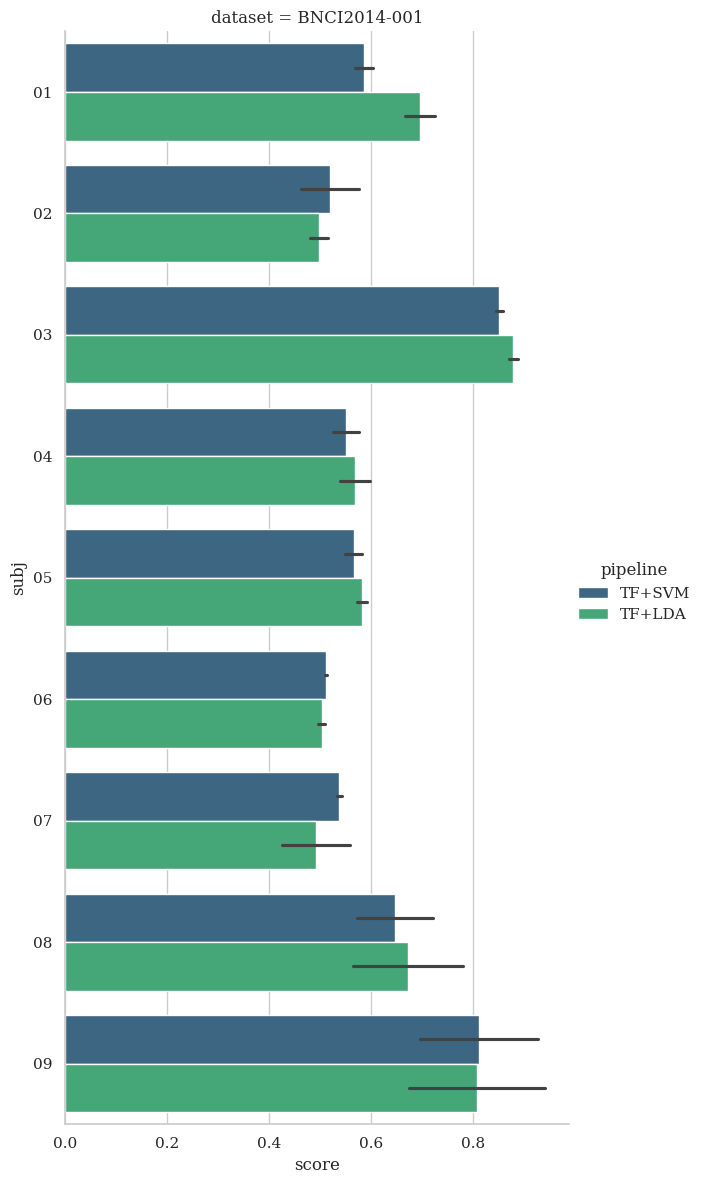

In [14]:
plot_performance(results)


## Feature Engineering: Common Spatial Pattern (CSP)

The first EEG was recorded in 1929. However, BCI research didn't take off until the late 1960s. Early EEG classification relied heavily on signal processing techniques from time and frequency domain feature extraction. Furthermore, the best performing classifiers were highly complex. A major shift to ML classification came in 2000 with spatial filters like common spatial pattern (CSP). Not only did this feature engineering technique dramatically improve EEG classification performance for BCI research, but it did so successfully with simple classifiers [Nam2018]. See the [supplementary material](https://github.com/davisethan/FeatureEngineering/blob/main/FeatureEngineering.pdf) at the end of this notebook for a mathematically motivated explanation of CSP. We'll use [PyRiemann](https://pyriemann.readthedocs.io/en/latest/) for CSP spatial filtering, and again when we visit current state of the art feature engineering for EEG.

Text(0.5, 1.02, 'CSP Features: Class Separability')

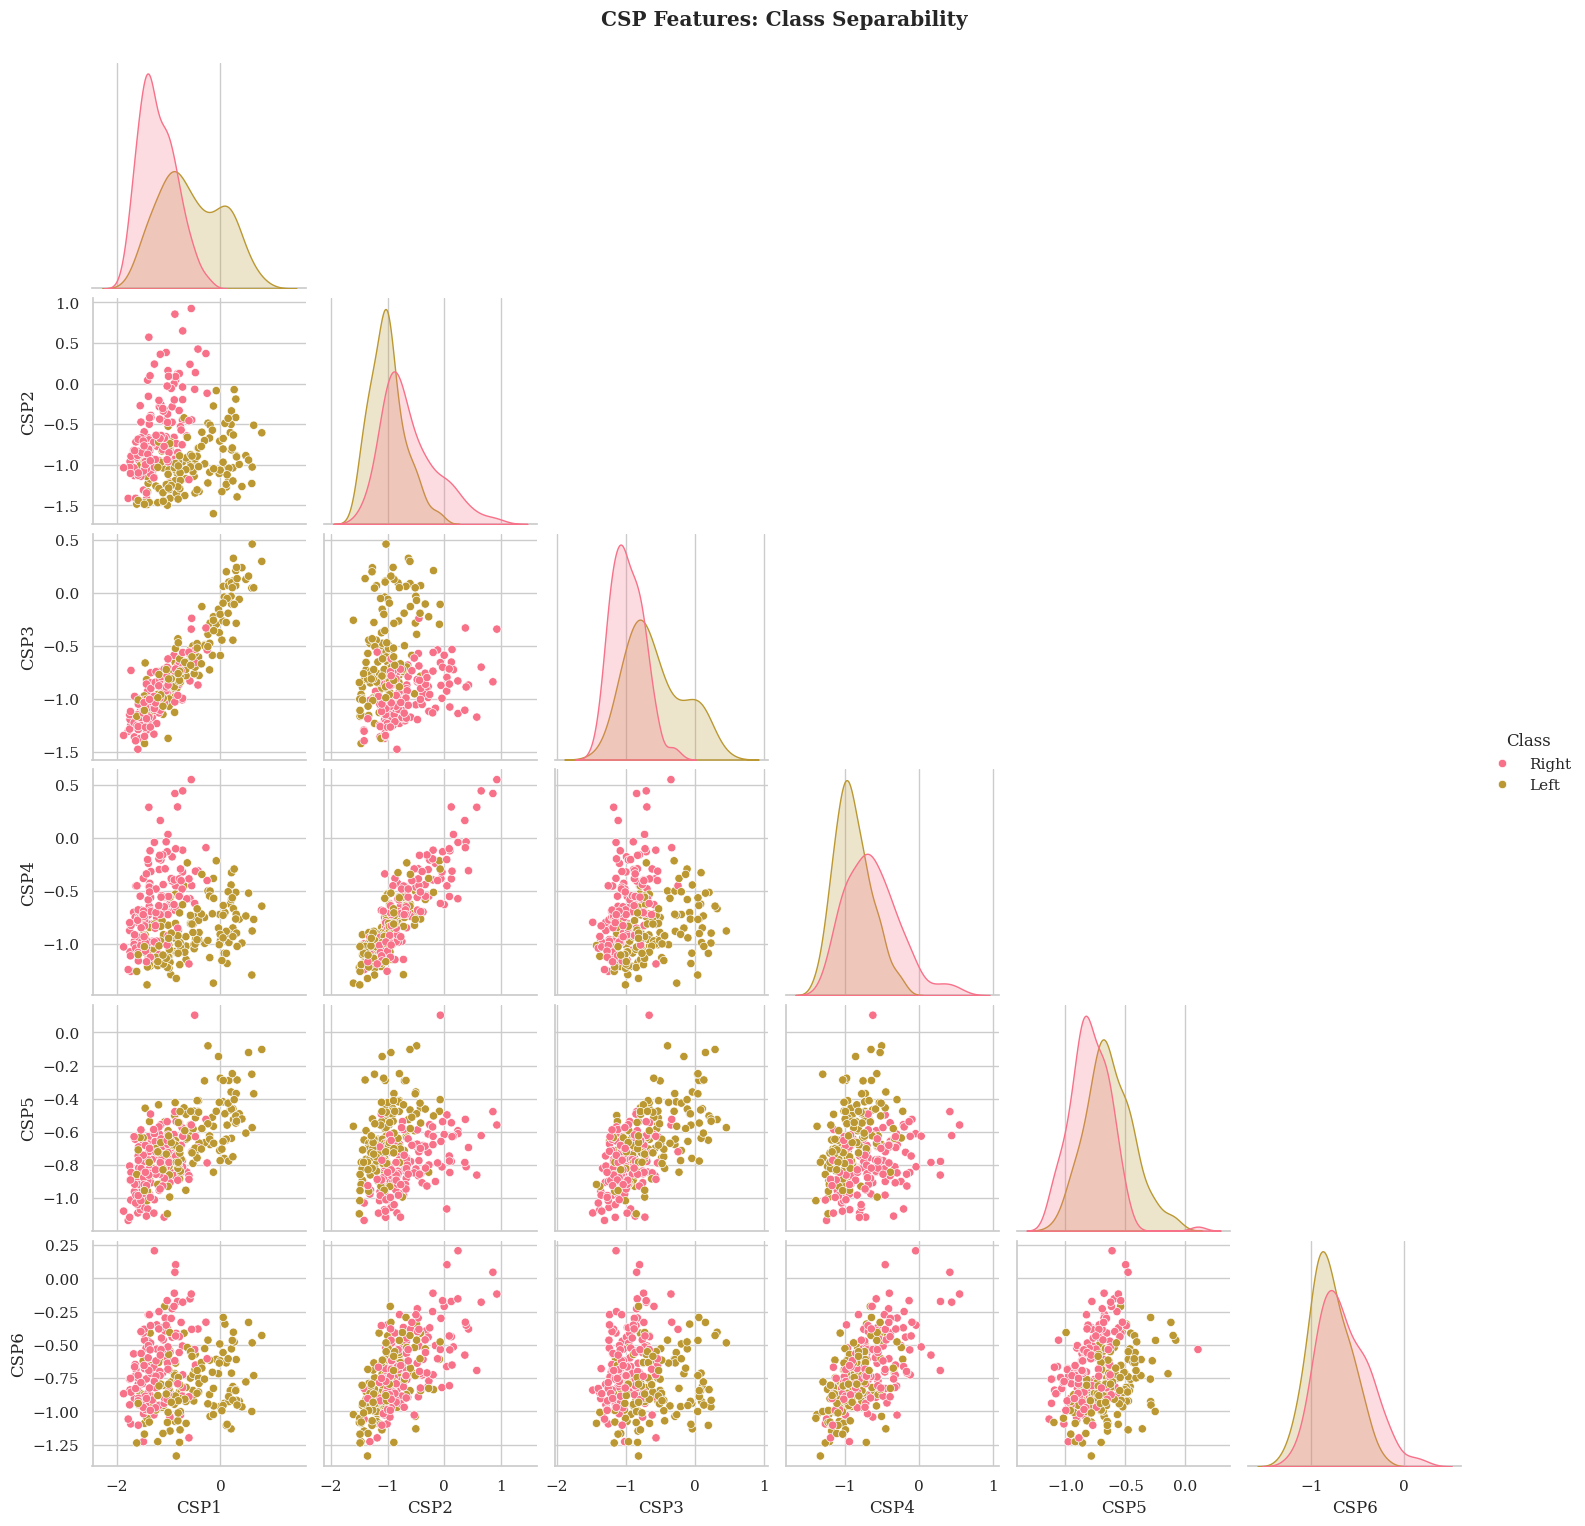

In [15]:
# Compute covariance matrices for each trial
# Average over left vs. right imagery class
cov = Covariances(estimator="oas")
X_cov = cov.fit_transform(X)

# Maximize variance of one class
# And minimize variance of the other class at the same time
csp = CSP(nfilter=6)
X_csp = csp.fit_transform(X_cov, y)

# Visualize pairplots of CSP features
# Notice better class separation than time/frequency domain features
df_csp = pd.DataFrame(X_csp, columns=["CSP1", "CSP2", "CSP3", "CSP4", "CSP5", "CSP6"])
df_csp["Class"] = ["Left" if y[i] == "left_hand" else "Right" for i in range(len(y))]
sns.pairplot(df_csp, hue="Class", corner=True, diag_kind="kde")
plt.suptitle("CSP Features: Class Separability", y=1.02, fontweight="bold")

In [16]:
# Define CSP pipelines
pipelines.update({
    "CSP+LDA": make_pipeline(
        Covariances(estimator="oas"),
        CSP(nfilter=6),
        LDA(solver="svd"),
    ),
    "CSP+SVM": make_pipeline(
        Covariances(estimator="oas"),
        CSP(nfilter=6),
        SVC(C=1.0, kernel="rbf"),
    )
})

# Score CSP pipelines by AUROC
results = evaluation.process(pipelines)
print(results.shape)
print(results.head())

BNCI2014-001-WithinSession: 100%|██████████| 9/9 [00:34<00:00,  3.81s/it]


(72, 9)
      score      time  samples subject session  channels  n_sessions  \
0  0.938844  0.067742    144.0       1  0train        22           2   
1  0.960816  0.071661    144.0       1   1test        22           2   
2  0.616939  0.068657    144.0       2  0train        22           2   
3  0.497347  0.068622    144.0       2   1test        22           2   
4  0.992313  0.070557    144.0       3  0train        22           2   

        dataset pipeline  
0  BNCI2014-001  CSP+SVM  
1  BNCI2014-001  CSP+SVM  
2  BNCI2014-001  CSP+SVM  
3  BNCI2014-001  CSP+SVM  
4  BNCI2014-001  CSP+SVM  


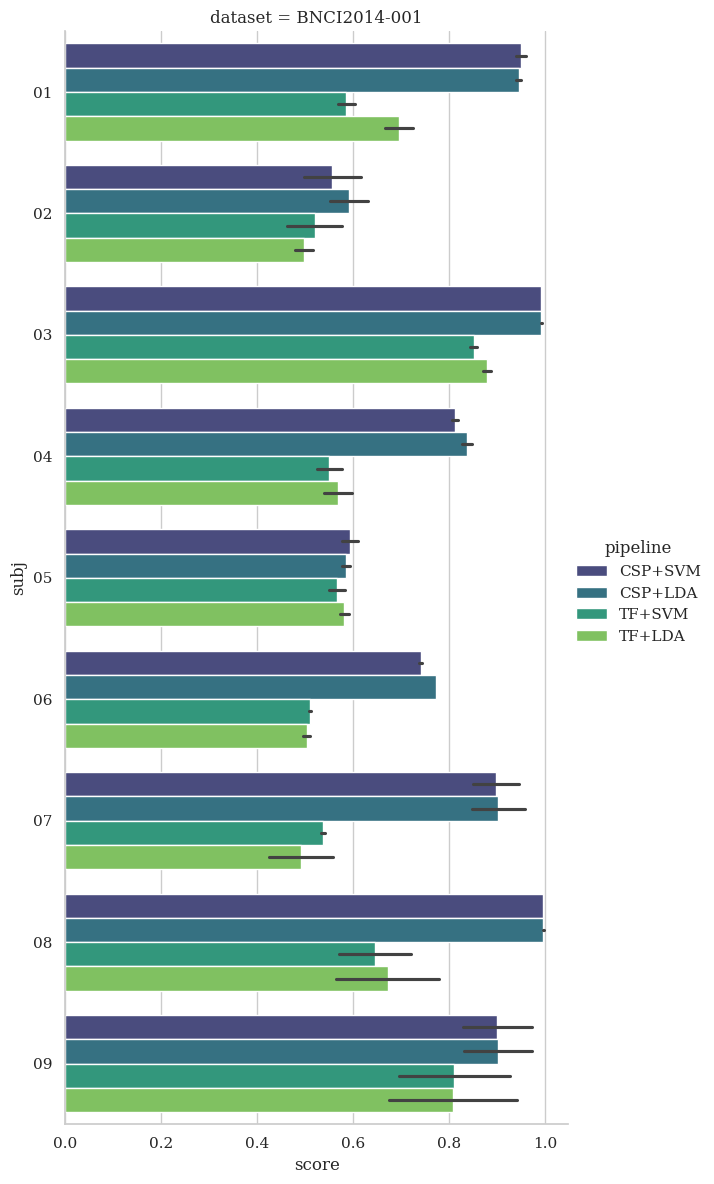

In [17]:
plot_performance(results)

## Feature Engineering: Current State of the Art

![SPD Manifold](https://raw.githubusercontent.com/davisethan/FeatureEngineering/main/assets/spd.png)

In the early 2010s another major wave came to BCI research and EEG classification through Riemannian geometry [Julia2024]. These achievements were built on theoretical advances by researchers working on information geometry and its applications to signal processing [Nam2018]. Riemannian metrics correctly measure norms, distances, and other statistics for structures like symmetric positive definite (SPD) covariance matrices unlike Euclidean metrics that are approximations and used by CSP [Pennec2019]. For an in depth overview of Riemannian geometric statistics relevant to state of the art BCI research see the [supplementary material](https://github.com/davisethan/FeatureEngineering/blob/main/FeatureEngineering.pdf) of this notebook.

We recommend using [PyRiemann](https://pyriemann.readthedocs.io/en/latest/) for researching Riemannian EEG classification. It's built for BCI research. For general purpose Riemannian geometric ML research we recommend [Geomstats](https://pyriemann.readthedocs.io/en/latest/). This also offers documentation for a friendly introduction to Riemannian geometric statistics. If interested in a textbook, we recommend [Pennec2019] which provides balanced theory and applications in a way that's friendly to ML researchers and medical practitioners. This textbook condenses concepts from topological, differential, and Riemannian manifolds which are often covered in separate graduate courses in mathematics. Its much briefer overiew often sacrifices mathematics rigor to instead provide intuitive reasons for the mathematical definitions [Pennec2019].

In [18]:
cov = Covariances(estimator="oas")
X_cov = cov.fit_transform(X)

ts = TangentSpace(metric="riemann")
X_ts = ts.fit_transform(X_cov)

print(f"Tangent space features: {X_ts.shape}")

Tangent space features: (288, 253)


BNCI2014-001-WithinSession: 100%|██████████| 9/9 [00:34<00:00,  3.81s/it]


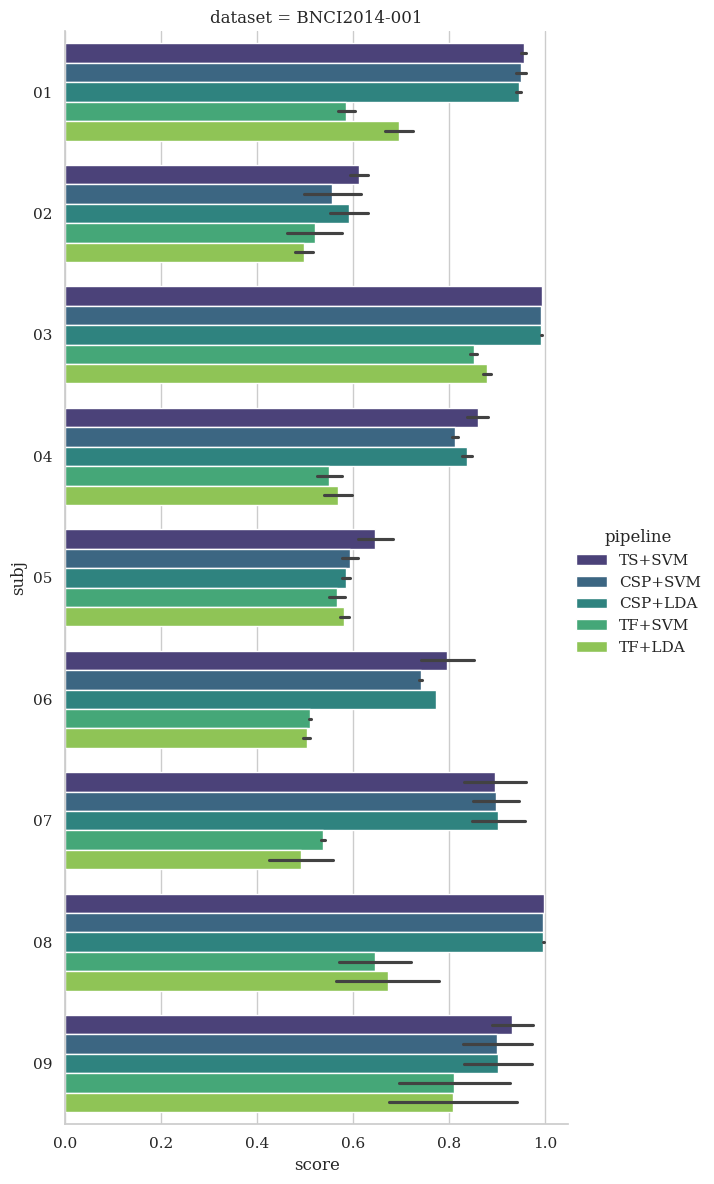

In [19]:
pipelines.update({
    "TS+SVM": make_pipeline(
        Covariances(estimator="oas"),
        TangentSpace(metric="riemann"),
        SVC(C=1.0, kernel="rbf"),
    )
})

results = evaluation.process(pipelines)

plot_performance(results)

## Feature Engineering: Active Research

![ShallowFBCSPNet](https://raw.githubusercontent.com/davisethan/FeatureEngineering/main/assets/shallow-cnn.jpg)

The success of deep learning (DL) is widely known from image, text, and speech recognition and generation. One of its defining characteristics separating it from other ML algorithms is its automated feature extraction. Many complex and nonlinear layers of feature engineering and selection occur before often simple linear classification [Bishop2023]. For EEG this means the raw signals with potentially minimal to light preprocessing are used as input to the DL model. However, DL performance for BCI research is modest at best often being outperformed by much cheaper and simpler spatial filter models using CSP or Riemannian metrics [Chevallier2024]. An explanation for this is that DL algorithms require massive datasets for training which is often unavailable for EEG.

Regardless of its moderate success in EEG classification so far, DL is still highly active research. We recommend using [BrainDecode](https://braindecode.org/stable/index.html) for anyone interested in BCI and DL research. In this notebook we show how one of the most successful convolutional neural networks (CNNs) to date compares to previous algorithms we've seen. This CNN is ShallowFBCSPNet and sometimes referred to ShallowConvNet. Diagrammed above is the backbone architecture of ShallowConvNet [Schirrmeister2017]. Further recent DL research for EEG includes spatial modeling such as graph neural networks (GNNs) and temporal modeling such as attention/transformers. In addition to BrainDecode, we refer interested readers to [TorchEEG](https://torcheeg.readthedocs.io/en/latest/) for DL BCI research.



BNCI2014-001-WithinSession: 100%|██████████| 9/9 [17:36<00:00, 117.35s/it]


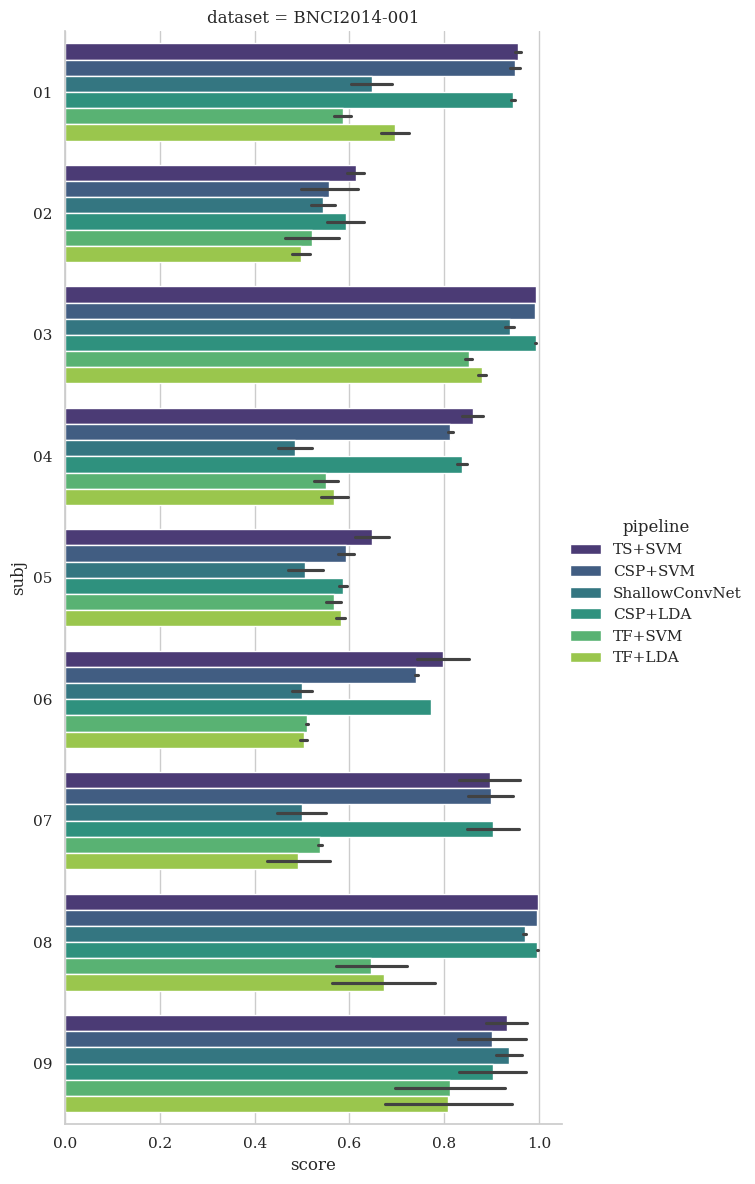

In [20]:
set_random_seeds(seed=1, cuda=torch.cuda.is_available())
pipelines.update({
    "ShallowConvNet": make_pipeline(
        EEGClassifier(
            ShallowFBCSPNet(
                n_chans=X.shape[1],
                n_outputs=len(np.unique(y)),
                n_times=X.shape[2],
            ),
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            optimizer__weight_decay=0.01,
            max_epochs=100,
            batch_size=64,
            train_split=ValidSplit(cv=0.2, random_state=1),
            iterator_train__shuffle=True,
            iterator_train__num_workers=0,
            iterator_valid__shuffle=False,
            iterator_valid__num_workers=0,
            verbose=0,
            device="cuda" if torch.cuda.is_available() else "cpu",
            callbacks=[
                EarlyStopping(
                    monitor="valid_loss",
                    patience=50,
                    threshold=0.0001,
                    lower_is_better=True,
                    load_best=True,
                ),
                LRScheduler(
                    policy="ReduceLROnPlateau",
                    monitor="valid_loss",
                    patience=20,
                    factor=0.5,
                    mode="min",
                    min_lr=1e-6,
                ),
            ],
        ),
    )
})

results = evaluation.process(pipelines)

plot_performance(results)

## Conclusion

Above we have seen how feature engineering can mean the difference between models with AUROC averaging around 60% vs. close to 90%. Searching the feature space for optimal predictors can be costly. The exhaustive search (ES) algorithm is capable of finding the globally optimal features for a model but in practice it's intractable. A simple and widely accepted algorithm for searching feature space is grid search which linearly iterates through predefined combinations of predictors. In addition to being slow, in high dimensions grid search is known for sparse coverage of feature space [Tsai2023]. Pseudo-random sampling methods like Sobol sampling or Latin hypercubes are better suited for higher dimensional feature space because they offer better coverage and speed [Renardy2021].

![EEG instrumentation](https://raw.githubusercontent.com/davisethan/FeatureEngineering/main/assets/sampling.png)

Although fast, feature space sampling methods are uninformative meaning they do not learn during their exploration of the feature space [Renardy2021]. An alternative to these techniques is greedy search [Kuhn2019]. Though, while greedy search is fast it's known for early convergence in local optima [Tsai2023]. Meta-heuristic algorithms are a class of stochastic methods that balances learning exploration and exploitation from searching feature space to avoid early convergence [Tsai2023]. Examples of meta-heuristic algorithms includes simulated annealing (SA), genetic algorithms (GA), and swarm intelligence algorithms [Kuhn2019, Tsai2023]. Feature engineering and selection for ML models is active research because as we've seen it's capable of improving  statistical models from our daily lives.

## Supplementary Material

[View PDF](https://github.com/davisethan/FeatureEngineering/blob/main/assets/FeatureEngineering.pdf)

## References

**[Kuhn2019]** Kuhn, M., & Johnson, K. (2019). Feature Engineering and Selection: A Practical Approach for Predictive Models (1st ed.). Chapman and Hall/CRC. https://doi.org/10.1201/9781315108230

**[Nam2018]** Nam, C.S., Nijholt, A., & Lotte, F. (Eds.). (2018). Brain–Computer Interfaces Handbook: Technological and Theoretical Advances (1st ed.). CRC Press. https://doi.org/10.1201/9781351231954

**[Corsi2023]** Corsi, MC. (2023). Electroencephalography and Magnetoencephalography. In: Colliot, O. (eds) Machine Learning for Brain Disorders. Neuromethods, vol 197. Humana, New York, NY. https://doi.org/10.1007/978-1-0716-3195-9_9

**[Cortex2014]** File:Human motor cortex.jpg - Wikimedia Commons. (2014, July 14). https://commons.wikimedia.org/wiki/File:Human_motor_cortex.jpg

**[Homunculus2016]** File:Motor Homunculus.svg - Wikimedia Commons. (2016, June 11). https://commons.wikimedia.org/wiki/File:Motor_homunculus.svg

**[Tangermann2012]** Tangermann, M., Muller, K.R., Aertsen, A., Birbaumer, N., Braun, C., Brunner, C., Leeb, R., Mehring, C., Miller, K.J., Mueller-Putz, G. and Nolte, G., 2012. Review of the BCI competition IV. Frontiers in neuroscience, 6, p.55.

**[Pfurtscheller1999]** Pfurtscheller, G., & Lopes da Silva, F. H. (1999). Event-related EEG/MEG synchronization and desynchronization: basic principles. Clinical Neurophysiology, 110(11), 1842–1857. https://doi.org/10.1016/S1388-2457(99)00141-8

**[Hjorth1970]** Hjorth, B. (1970). EEG analysis based on time domain properties. Electroencephalography and Clinical Neurophysiology, 29(3), 306–310. https://doi.org/10.1016/0013-4694(70)90143-4

**[Chevallier2024]** Chevallier, S., Carrara, I., Aristimunha, B., Guetschel, P., Sedlar, S., Lopes, B., Velut, S., Khazem, S., & Moreau, T. (2024). The largest EEG-based BCI reproducibility study for open science: the MOABB benchmark. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2404.15319

**[Jayaram2018]** Jayaram, V., & Barachant, A. (2018). MOABB: trustworthy algorithm benchmarking for BCIs. Journal of Neural Engineering, 15(6), 066011. https://doi.org/10.1088/1741-2552/aadea0

**[Julia2024]** Symmetric positive definite · Manifolds.jl. (n.d.). https://juliamanifolds.github.io/Manifolds.jl/v0.1/manifolds/symmetricpositivedefinite.html

**[Pennec2019]** Pennec, X., Sommer, S., & Fletcher, T. (2019). Riemannian Geometric statistics in medical image analysis. In Elsevier eBooks. https://doi.org/10.1016/c2017-0-01561-6

**[Bishop2023]** Bishop, C. M., & Bishop, H. (2023). Deep learning: Foundations and Concepts. Springer Nature.

**[Schirrmeister2017]** Schirrmeister, R. T., Springenberg, J. T., Fiederer, L. D. J., Glasstetter, M., Eggensperger, K., Tangermann, M., Hutter, F. & Ball, T. (2017). Deep learning with convolutional neural networks for EEG decoding and visualization. Human Brain Mapping , Aug. 2017. Online: http://dx.doi.org/10.1002/hbm.23730

**[Star2021]** Star. (2021, September 5). why test error and variance has different curve in bias variance trade off graph? Cross Validated. https://stats.stackexchange.com/questions/543509/why-test-error-and-variance-has-different-curve-in-bias-variance-trade-off-graph

**[Tsai2023]** Tsai, C., & Chiang, M. (2023). Handbook of Metaheuristic Algorithms: From Fundamental Theories to Advanced Applications. Elsevier.

**[Renardy2021]** Renardy, M., Joslyn, L. R., Millar, J. A., & Kirschner, D. E. (2021). To Sobol or not to Sobol? The effects of sampling schemes in systems biology applications. Mathematical Biosciences, 337, 108593. https://doi.org/10.1016/j.mbs.2021.108593